# Séries Temporelles :

## Sommaire :

* [**1.Introduction**](#0)

* [**2.Tendance**](#1)
    * [2.1. Méthode par régréssion](#1.1)
    * [2.2. Méthode par moyenne mobile](#1.2)
    
* [**3.Saisonnalité**](#2)
    * [3.1 Méthodes par régression](#2.1)
        * [A. Buys Ballot](#2.1.1)
        * [B. STL (Seasonal decomposition of Time series)](#2.1.2)
    * [3.2 Méthodes par moyenne mobile ](#2.2)
    * [3.3 Méthodes Transformée de Fourier, FTT (fast fourier transform) et machine learning](#2.3)

## 1. Introduction :

Définition : Une série temporelle (ou encore une série chronologique) est une suite finie $(x_1, · · · , x_n)$ de données indexées par le temps.

Objectif de l'étude de séries temporelles :
* Trouver les composantes de la série (saisonnalité, bruit, tendance) pour en déduire des propriétés 
* Prévoir : établir des modèles de prédictions 
* Détection de rupture : Déterminer les instants où les paramètres de la série se modifient

### Définition des caractéristiques importantes : 

* Stationarité : Une série $(Xt)$ est stationnaire si ses propriétés probabilistes sont les mêmes que celles de la série $(Xt+h)$, pour tout entier h.

Les bruits sont en général considéré comme stationnaire.
Rendre un processus stationnaire peut être intéressant pour plusieurs raison mais notamment pour obtenir une espérance et une covariance constantes.

Une idée naturelle est de rechercher d’abord, au vu des données, la meilleure fonction déterministe dt telle que le résidu xt − dt soit raisonnablement stationnaire.

#### Premier Modèle : 

$$X_t = M_t + S_t + Z_t$$

* $M_t$ : Tendance, fonction qui varie lentement
* $S_t$ : Saisonnalité (périodique)
* $Z_t$ : Partie aléatoire, Bruit

#### Exemple : S&P 500

Pour chaque application numérique dans ce projet, nous allons prendre et utiliser l'exemple du S&P500, un des indices boursier américain.

In [175]:
import numpy as np
import requests  # Connexion à l'API de AlphaVantage
import matplotlib.pyplot as plt
from scipy.optimize import minimize

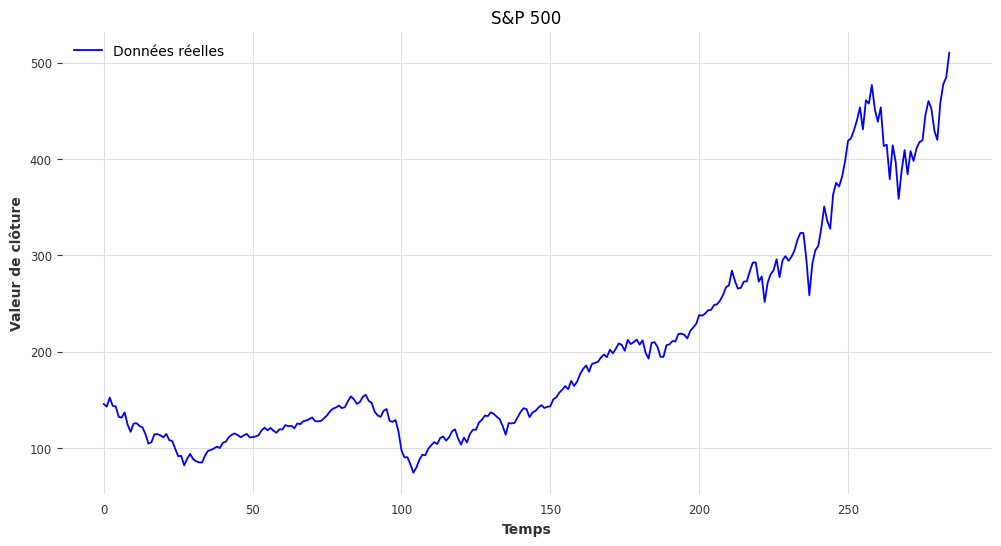

In [240]:
# Exemple S&P 500
symbol = 'IVV'

# Clé personelle Alpha Vantage
key_API = 'LYMJQ6KR5QPKJ8W3'

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={symbol}&apikey={key_API}'
r = requests.get(url)
data_json = r.json()

# Accès au sous-dictionnaire contenant les données
time_series = data_json['Monthly Adjusted Time Series']

# Extraction des données de clôture (4. close) en tant que tableau NumPy
closing_prices = np.array([float(entry['4. close']) for entry in time_series.values()])

# Ordre temporaire 
closing_prices = closing_prices[::-1]

abscisse = [i for i in range(len(closing_prices))]

# Data visualisation
plt.figure(figsize=(12, 6))
plt.plot(abscisse, closing_prices, label='Données réelles', color='blue')
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('S&P 500')
plt.legend()
plt.show()

## 2. Tendance / Trend ($M_t$):

### 2.1 Méthode par régression :

**Guys Ballot :** La méthode de Buys-Ballot généralisée consiste à spécifier les composantes déterministes (trend et saison) comme une combinaison linaire de fonctions connues du temps, puis à effectuer une régression linéaire ordinaire.


Le modèle le plus populaire pour estimer une tendance est le modèle de tendance polynomiale : 

$$M_t = a_0 + a_1t + ... + a_dt^d$$

Dans ce modèle : 
* On repère une approximation de d par data visualisation
* On peut estimer le vecteur a par la méthode des moindres carrés.

$$â = \text{arg min}_a \sum_{t=1}^{n} (x_t - m_t)^2$$

D'après nos cours de modèles linéaires généralisés : 

En posant:

$$A = \begin{bmatrix}
1 & t_1 & t_1^2 & \ldots & t_1^d \\
1 & t_2 & t_2^2 & \ldots & t_2^d \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & t_n & t_n^2 & \ldots & t_n^d
\end{bmatrix}, X = \begin{pmatrix} x_1 \\ \vdots \\ x_n \end{pmatrix}, a = \begin{pmatrix} a_1 \\ \vdots \\ a_d \end{pmatrix}$$

On obtient :

$$â = (A^TA)^{-1}A^TX$$


In [200]:
# Implémentation de l'algo

def tendance(d, X):
    # Création de A
    A = np.array([[k**i for i in range(d+1)] for k in range(len(X))])

    # Calcul des coefficients
    B = np.dot(A.T, A)
    B_inverse = np.linalg.inv(B)
    C = np.dot(A.T, X)
    result = np.dot(B_inverse, C)
    
    return result

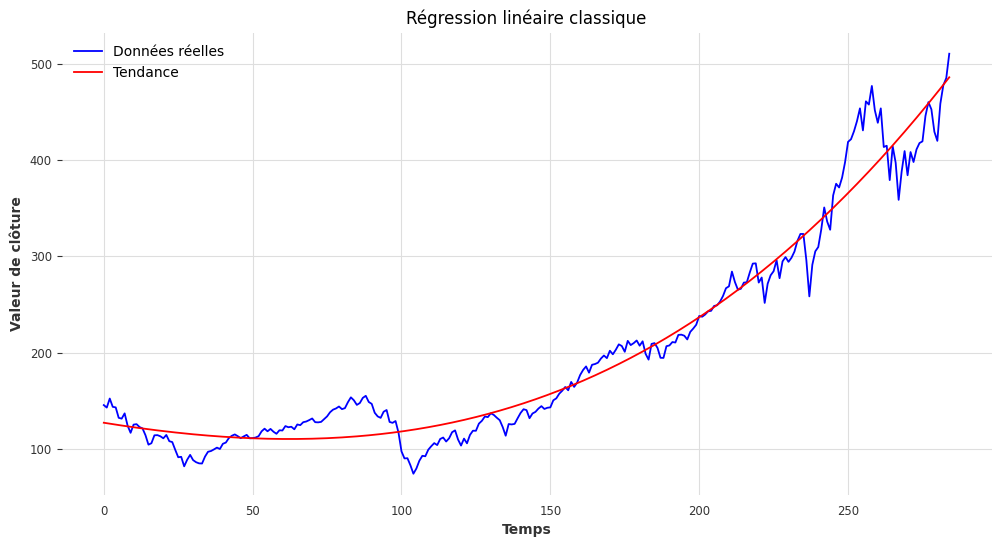

In [241]:
# Détermination tendance
a = tendance(3, closing_prices)

def f_tendance(t):
    return(a[0] + a[1] * t + a[2] * (t ** 2) + a[3] * (t ** 3))

abscisse = [i for i in range(len(closing_prices))]

# Data visualisation
plt.figure(figsize=(12, 6))
plt.plot(abscisse, closing_prices, label='Données réelles', color='blue')
plt.plot(f_tendance(np.array(abscisse)), label='Tendance', color='red')
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.legend()
plt.title('Régression linéaire classique')
plt.show()

Conclusion : L'algorithme fonctionne 

### 2.2 Méthode Moyenne mobile :

**Défintion :** La moyenne mobile d’ordre m1 + m2 + 1 est définie par :

$$MX_t = \theta _{-m_1}X_{t-m_1} + \theta _{-m_1+1}X_{t-m_1+1} + \ldots + \theta _{m_2}X_{t+m_2}$$

Remarque : 

* Pour $T$ observations, on a : $m_1 < t < T-m_2$
* La moyenne mobile est dite symétrique si $m_1 = m_2$
* La contrainte $\sum_{j=-m_1}^{m-2}\theta_j = 1$ permet de garder les constantes, si en plus symétrique la MM conserve également les polynômes de degré 1



**Moyenne mobile arithmétique :**

La MM symétrique qui conserve la contrainte $\sum_{j=-m}^{m}\theta_j = 1$ qui a le plus grand pouvoir de réduction de la variance du bruit est la MM arithmétique :

**$$\theta_j = \frac{1}{2m+1}$$**

Elle s'obtient grâce à l'optimisation suivante :
$\min_{\theta} \sum_{j=-m}^{m} \theta_j^2$ avec la contrainte $\sum_{j=-m}^{m} \theta_j = 1$


Propriétés :
* Elle annule les périodes de saison $2m+1$ 
* Elle conserve les polynômes de degré 1

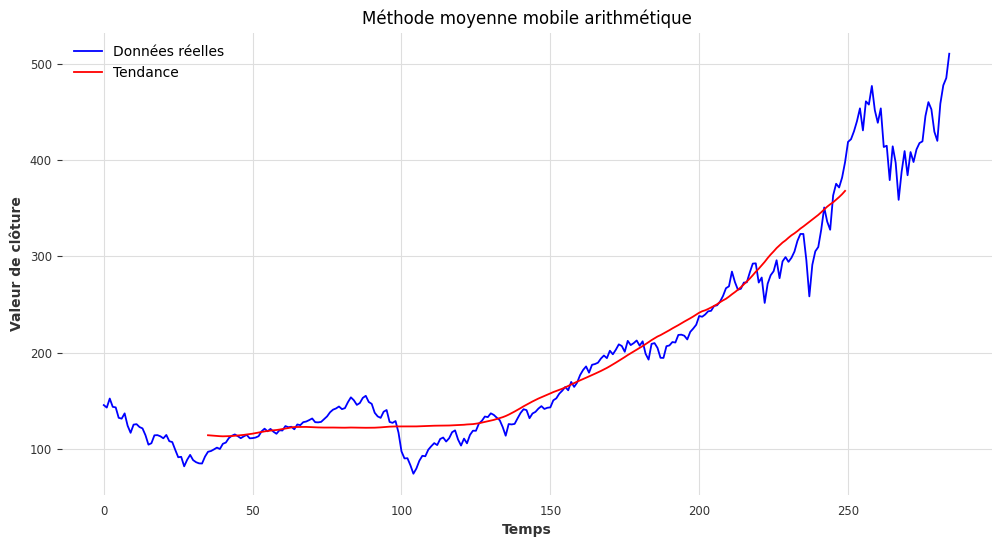

In [242]:
# Implémentation de l'algo
# Valeur de notre p = 2m + 1

p = 71  # Doit être impair
m = 0.5 * (p - 1)
theta = 1 / p  # Valeur de mes thetas (constants)
X_sym = []

for k in range(int(m), int(len(closing_prices) - m)):
    s = 0
    for j in range(p):
        s += theta * closing_prices[int(j + k - m)]
    X_sym.append(s)

# Visualisation
abscisse = [i for i in range(len(closing_prices))]
abscisse_filter = [i for i in range(int(m), len(closing_prices) - int(m))]

# Data visualisation
plt.figure(figsize=(12, 6))
plt.plot(abscisse, closing_prices, label='Données réelles', color='blue')
plt.plot(abscisse_filter, X_sym, label='Tendance', color='red')
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('Méthode moyenne mobile arithmétique')
plt.legend()
plt.show()

## 3. Saisonnalité ($S_t$):

### 3.1 Méthodes par régression :

#### A. Buys Ballot :

**Guys Ballot :** La méthode de Buys-Ballot généralisée consiste à spécifier les composantes déterministes (trend et saison) comme une combinaison linaire de fonctions connues du temps, puis à effectuer une régression linéaire ordinaire.

Le modèle le plus populaire pour estimer la saisonnalité est le modèle trigonométrique suivant:

$$s_t = a_0 + \sum_{j=1}^{k} (a_jcos(\lambda_jt) + b_jsin(\lambda_jt))$$

Dans ce modèle : 
* On va supposer $\lambda$ constant et égal à $2\pi/d$, avec $d$ à déterminer par visualisation graphique.

* On peut estimer le vecteur a par la méthode des moindres carrés (Si $\lambda$ constant, alors $a$ est de dimension 3)

$$â = \text{arg min}_a \sum_{t=1}^{n} (x_t - m_t)^2$$

D'après nos cours de modèles linéaires généralisés : 

En posant:

$$A = \begin{bmatrix}
1 & cos(\lambda t_1) & sin(\lambda t_1) \\
1 & cos(\lambda t_2) & sin(\lambda t_2) \\
\vdots & \vdots & \vdots  \\
1 & cos(\lambda t_n) & sin(\lambda t_n)
\end{bmatrix}, X = \begin{pmatrix} x_1 \\ \vdots \\ x_n \end{pmatrix}, a = \begin{pmatrix} a_0 \\ a_1 \\ b_1 \end{pmatrix}$$

On obtient :

$$â = (A^TA)^{-1}A^TX$$

In [80]:
# Implémentation de l'algo

def saison(d, X):
    X_saison = [X[k] - f_tendance(k) for k in range (len(X))]
    l = (2 * np.pi)/d
    # Création de A
    A = np.array([[1, np.cos(l*X_saison[k]), np.sin(l*X_saison[k])] for k in range(len(X))])

    # Calcul des coefficients
    B = np.dot(A.T, A)
    B_inverse = np.linalg.inv(B)
    C = np.dot(A.T, X_saison)
    result = np.dot(B_inverse, C)
    
    return result

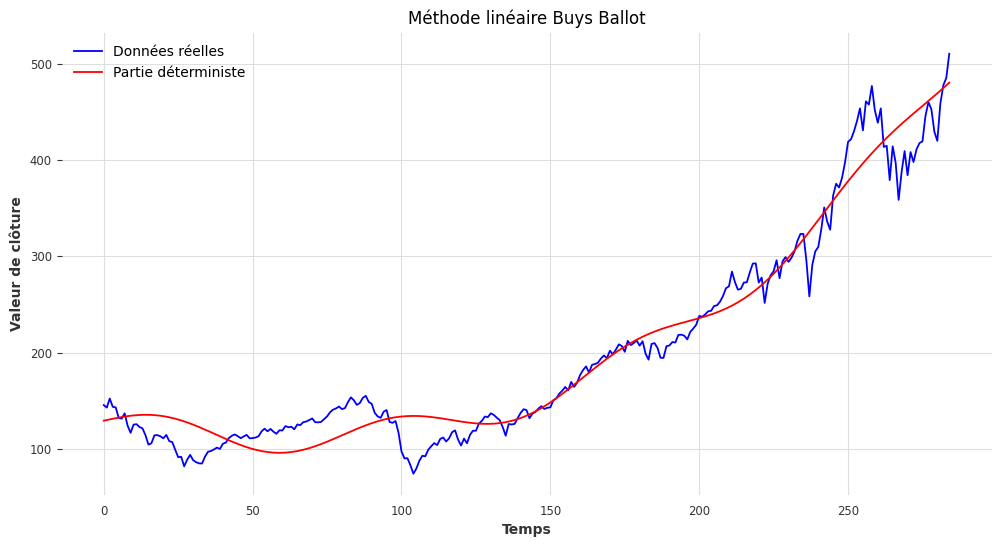

In [243]:
# Vérification graphique 
# D'après le graphique au dessus, en évaluant la période on a d = 80 (regarde quand la courbe rouge passe au dessous de la bleu)
d = 80

s = saison(d, closing_prices)

def f_saison(t):
    return(s[0] + s[1] * np.cos(t * (2 * np.pi)/d) + s[2] * np.sin(t * (2 * np.pi)/d))

def partie_derterministe(t):
    return(f_tendance(t) + f_saison(t))

abscisse = [i for i in range(len(closing_prices))]

# Data visualisation
plt.figure(figsize=(12, 6))
plt.plot(abscisse, closing_prices, label='Données réelles', color='blue')
plt.plot(partie_derterministe(np.array(abscisse)), label='Partie déterministe', color='red')  # Utilisez np.array(abscisse) pour la fonction poly
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('Méthode linéaire Buys Ballot')
plt.legend()
plt.show()

Remarque : Légère asymétrie autour de 80 mois, principalement liée à cause des $\lambda$ constants, la période est pas réellement constante.
Pour cette raison, la méthode STL semble fortement pertinente.

#### B. STL (Seasonal decomposition of Time Series) :

**STL** : La méthode STL (Seasonal decomposition of Time series by Loess) consiste à spécifier les composantes déterministes comme une combinaison linaire de fonctions simples et connues du temps, puis à effectuer localement des régressions linéaires ordinaires. (On applique Guys Ballot sur une discrétisation de la série)

Nous allons donc utiliser le même modèle :
$$s_t = a_0 + \sum_{j=1}^{k} (a_jcos(\lambda_jt) + b_jsin(\lambda_jt))$$

Dans ce modèle : 
* On va supposer $\lambda$ constant et égal à $2\pi/d$, avec $d$ à déterminer par visualisation graphique.

* On peut estimer le vecteur a par la méthode des moindres carrés (Si $\lambda$ constant, alors $a$ est de dimension 3)

$$â = \text{arg min}_a \sum_{t=1}^{n} (x_t - m_t)^2$$

D'après nos cours de modèles linéaires généralisés : 

En posant:

$$A = \begin{bmatrix}
1 & cos(\lambda t_1) & sin(\lambda t_1) \\
1 & cos(\lambda t_2) & sin(\lambda t_2) \\
\vdots & \vdots & \vdots  \\
1 & cos(\lambda t_n) & sin(\lambda t_n)
\end{bmatrix}, X = \begin{pmatrix} x_1 \\ \vdots \\ x_n \end{pmatrix}, a = \begin{pmatrix} a_0 \\ a_1 \\ b_1 \end{pmatrix}$$

On obtient :

$$â = (A^TA)^{-1}A^TX$$

In [220]:
# Implémentation de l'algo
def saison_stl (d, X):
    a = tendance(3, X)

    def f_tendance(t):
        return(a[0] + a[1] * t + a[2] * (t ** 2) + a[3] * (t ** 3))
    
    X_saison = [X[k] - f_tendance(k) for k in range (len(X))]
    l = (2 * np.pi)/d
    # Création de A
    A = np.array([[1, np.cos(l*X_saison[k]), np.sin(l*X_saison[k])] for k in range(len(X))])

    # Calcul des coefficients
    B = np.dot(A.T, A)
    B_inverse = np.linalg.inv(B)
    C = np.dot(A.T, X_saison)
    result = np.dot(B_inverse, C)
    
    return result

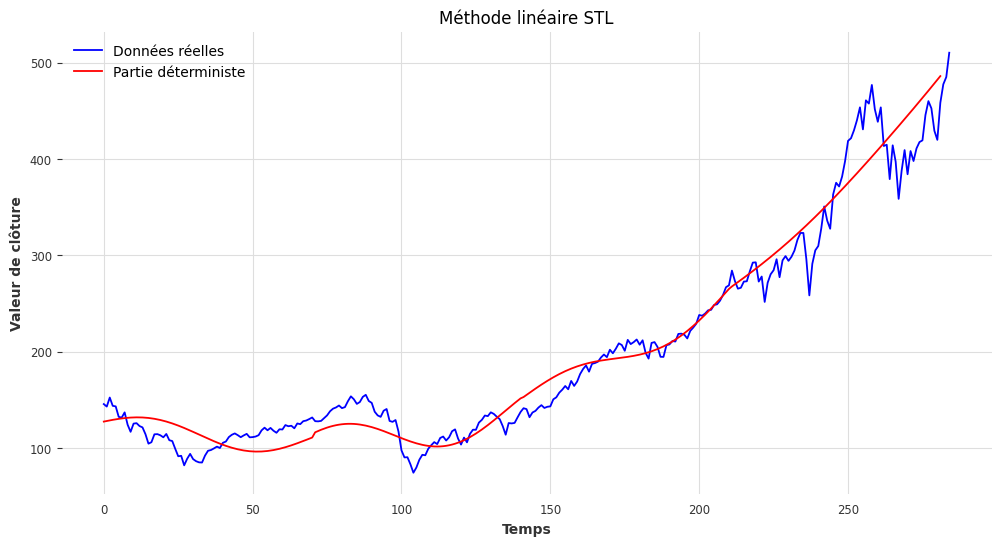

In [244]:
# Vérification graphique 
# D'après le graphique au dessus, en évaluant la période on a d = 70 (regarde quand la courbe rouge passe au dessous de la bleu)
d = 70

# Liste valeurs lissées
X_stl = []
# Tableau avec les coefs de la régression
s_stl = np.array([])

# Calcul des coefs pour chaque segments séparés
for k in range(1, 5):
    segment = saison_stl(d, closing_prices[71 * (k - 1) : 71 * k])
    s_stl = np.concatenate((s_stl, segment))

# Calcul de St + Mt pour chaque segment
for k in range (71):
        X_stl.append(s_stl[0] + s_stl[1] * np.cos(k * (2 * np.pi) / d) + s_stl[2] * np.sin(k * (2 * np.pi) / d) + f_tendance(k))
for k in range (72, 142):
        X_stl.append(s_stl[3] + s_stl[4] * np.cos(k * (2 * np.pi) / d) + s_stl[5] * np.sin(k * (2 * np.pi) / d) + f_tendance(k))
for k in range (143, 213):
        X_stl.append(s_stl[6] + s_stl[7] * np.cos(k * (2 * np.pi) / d) + s_stl[8] * np.sin(k * (2 * np.pi) / d) + f_tendance(k))
for k in range (214, 285):
        X_stl.append(s_stl[9] + s_stl[10] * np.cos(k * (2 * np.pi) / d) + s_stl[11] * np.sin(k * (2 * np.pi) / d) + f_tendance(k))


abscisse_stl = [i for i in range(len(closing_prices) - 3)]
abscisse = [i for i in range(len(closing_prices))]

# Data visualisation
plt.figure(figsize=(12, 6))
plt.plot(abscisse, closing_prices, label='Données réelles', color='blue')
plt.plot(abscisse_stl, X_stl, label='Partie déterministe', color='red')  # Utilisez np.array(abscisse) pour la fonction poly
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('Méthode linéaire STL')
plt.legend()
plt.show()

Remarque : Le résultat semble légèrement mieux que pour la méthode de Guys Ballot, cependant il reste quand même très approximatif.

### 3.2 Méthode Moyenne mobile :

**Rappel Défintion :** La moyenne mobile d’ordre m1 + m2 + 1 est définie par :

$$MX_t = \theta _{-m_1}X_{t-m_1} + \theta _{-m_1+1}X_{t-m_1+1} + \ldots + \theta _{m_2}X_{t+m_2}$$


#### **Moyennes mobiles d'Henderson :**

Les coefs $\theta$ se trouvent avec l'optmisation suivante:

$$\min_{\theta} \sum_{i} (\Delta ^3 \theta_i)^2  = \min_{\theta} \sum_{i} (\theta_i - 3\theta_{i-1} +3\theta_{i-2} - \theta_{i-3})^2$$ 

**Moyenne mobile d'Henderson d'ordre $2m-3$ :**

Pour $i \in [-m-1, m+1]$ :
$$\theta_i=\frac{315((m-1)^2-i^2)(m^2-i^2)((m+1)^2-i^2)(m^2-16-11i^2)}{8m(m^2-1)(4m^2-1)(4m^2-9)(4m^2-25)}$$
Propriété :
* Elle conserve les polynômes de degré 1 et 2 (utile pour notre exemple S&P 500)



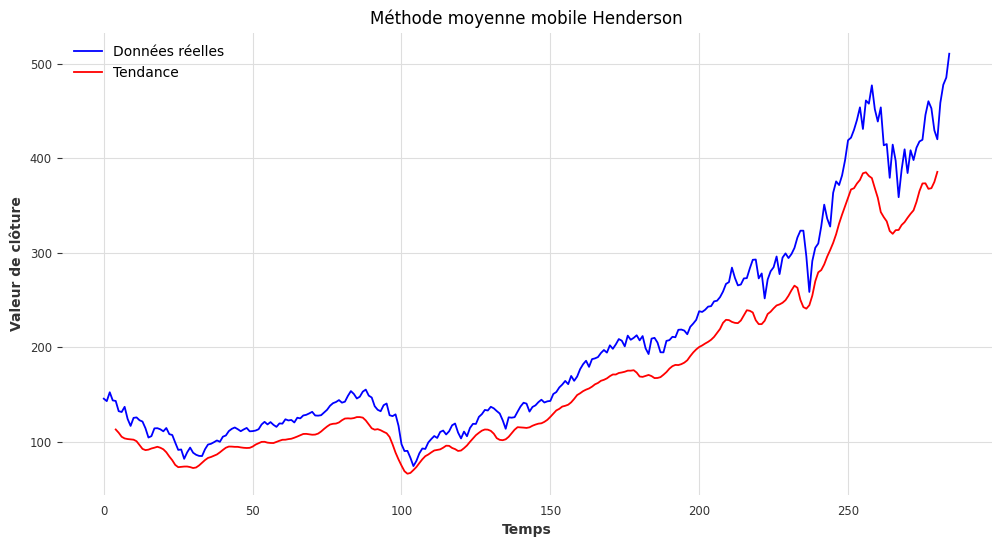

In [245]:
# Filtrage par Moyenne mobile
# Calcul des coefficients 
def theta(i, m):
    numerateur = 315 * ((m - 1)**2 - i**2) * (m**2 - i**2) * ((m + 1)**2 - i**2) * (3 * (m**2) - 16 - 11 * (i**2))
    denominateur = 8 * m * (m**2 - 1) * (4 * (m**2) - 1) * (4 * (m**2) - 9) * (4 * (m**2) - 25)
    return (numerateur/denominateur)

# Application S&P 500
m = 8
theta_SP = [theta(i, m) for i in range(-m+2, m-1)]

# Définition de la série lissée
price_filter = []

for k in range (len(closing_prices) - m):
    s = 0
    for j in range (m):
        s += theta_SP[j] * closing_prices[k + j]
    price_filter.append(s)

# Visualisation
abscisse = [i for i in range(len(closing_prices))]
abscisse_filter = [i for i in range(int(m/2), len(closing_prices) - int(m/2))]

# Data visualisation
plt.figure(figsize=(12, 6))
plt.plot(abscisse, closing_prices, label='Données réelles', color='blue')
plt.plot(abscisse_filter, price_filter, label='Tendance', color='red')
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('Méthode moyenne mobile Henderson')
plt.legend()
plt.show()

### 3.3 Transformée de Fourier discrète et FTT (Fast Fourier transform)

En effet, la problématique concernant la détermination de la saisonnalité revient à étudier les signaux périodiques d'une série.

**Résumé :**

L'objectif est d'approcher notre série $S_N(t)$, (ou $N$ représente la longueur de la série) par une fonction complexe :

$$S_N(t)=\sum_{k=0}^{N-1}C_k\exp(\frac{i2\pi kt}{N})\$$

Les coefficients $C_k$ se trouvent grâce à la DFT :

**Transformée de Fourier Discrète (DFT):**

$$DFT(f_k)=\sum_{n=0}^{N-1}S_N(n)\exp(-if_kn)$$

On a ensuite la relation :

$$ \| \text{DFT}(f_k) \|^2 = \| \mathcal{C}_k \|^2 $$

Remarque :
$\| \mathcal{C}_k \|^2 $ s'appelle le périodigramme, noté $P(f_k)$.

##### FTT :

Les FTT sont des algorithmes qui calculent les transformés de Fourier discrètes de façon très optimisée, évaluer les $C_k$ en utilisant les racines $n_{ie}$ de l'unité, ce qui permet de réduire considérablement la complexité de calcul.

Certains algorithmes d'apprentissage authomatique utilisent les FTT, on peut en retrouver au sein de la librairie "Darts".

In [82]:
from darts import TimeSeries
from darts.models import FFT

In [83]:
# Données stockage, nb données : 285
data_periodique = [closing_prices[k] - f_tendance(k) for k in range (len(closing_prices))]
data_periodique = np.array(data_periodique)
X_train = TimeSeries.from_values(data_periodique)

In [84]:
from darts import TimeSeries
from darts.models import FFT
model = FFT(nr_freqs_to_keep=10) # On décide de garder 10 fréquences pour éviter overfitting
model.fit(X_train)
pred_val_train = model.predict(len(X_train))

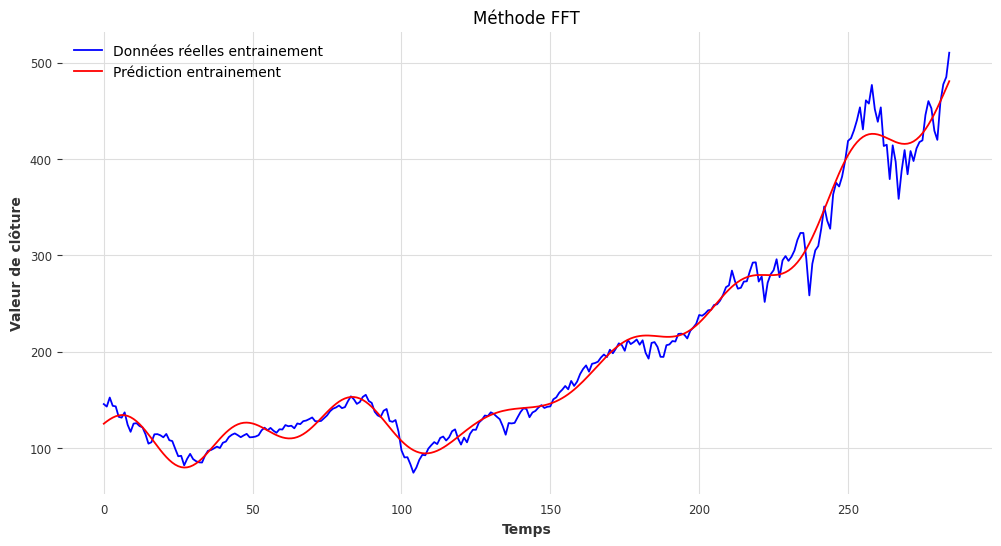

In [247]:
abscisse_train = [i for i in range(len(closing_prices))]

X_pred = [pred_val_train.values()[k] + f_tendance(k) for k in range(len(X_train))]

# Data visualization
plt.figure(figsize=(12, 6))
plt.plot(abscisse_train, closing_prices, label='Données réelles entrainement', color='blue')
plt.plot(abscisse_train, X_pred, label='Prédiction entrainement', color='red')
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('Méthode FFT')
plt.legend()
plt.show()

Remarque : Le résultat est déjà beaucoup plus satisfaisant. Les FTT sont des outils très puissants, mathématiquement, les fonctions periodiques cos et sin forment une base. Par conséquent, si on garde un nombre trop important de fréquence, on risque d'observer une composante sinusoïdale qui colle parfaitement la série et donc également le bruit blanc. (Overfitting)